<span style="color: orange; font-family: Calibri Light;">
  <h1><b>BERTopic Model: Default Parameters with slightly processed Text</b></h1>
</span>
<span style = "font-family: Calibri Light">
    In this model, we used the BerTopic model on slightly processed data
</span>

<span style="color: orange; font-family: Calibri Light;">
  <h2><b>I. Setup Environment</b></h2>
</span>

In [1]:
import os

os.environ['PATH'] = "/home/ec2-user/.local/bin:" + os.environ['PATH']

In [2]:
%pip install bertopic gensim

Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
  Obtaining dependency information for bertopic from https://files.pythonhosted.org/packages/06/49/f395e2e4d21dd49803494c8aec6087db61ea0ba211c6e5e57540b23334eb/bertopic-0.15.0-py2.py3-none-any.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.1/24.1 MB 30.4 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 10.0 MB/s eta 0:00:00:00:010:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.8/90.8 kB 1.3 MB/s eta 0:00:00ta 0:00:01
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 991.0 kB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... done
  Obtaining dependency information for plotly>=4.7.0 fr

In [1]:
pip freeze > requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np

import re

import ast
import csv
import os
import random
import time
import pickle
from collections import Counter

from glob import glob

#NLP libraries
from nltk import FreqDist
from gensim.models import Word2Vec
from gensim.utils import tokenize
from gensim.models.phrases import Phrases
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from gensim.corpora.dictionary import Dictionary
from gensim.models.coherencemodel import CoherenceModel

from bertopic import BERTopic
from bertopic.representation import MaximalMarginalRelevance, KeyBERTInspired
from bertopic.vectorizers import  ClassTfidfTransformer
from sentence_transformers import SentenceTransformer

#for vis
import matplotlib.pyplot as plt
import plotly.io as pio
pio.renderers.default = 'iframe'

from umap import UMAP

from sklearn.cluster import KMeans
from sentence_transformers import SentenceTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import silhouette_score

from hdbscan import HDBSCAN

2023-09-24 03:46:12.552311: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-24 03:46:25.055084: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-09-24 03:47:14.232897: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-09-24 03:47:14.233358: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] 

In [3]:
random.seed(880)  # Set the seed for Python's random module
np.random.seed(880)  # Set the seed for NumPy's random module

<span style="color: orange; font-family: Calibri Light;">
  <h2><b>II. Load and Pre-process Data</b></h2>
</span>

In [4]:
#access dataset files
folder_path = os.path.join("..", "../Data")
file_type = "*.csv"

#list of dataset file paths
document_path = glob(os.path.join(folder_path, file_type))

document_path

['../../Data/comments.csv',
 '../../Data/emoji_subset.csv',
 '../../Data/full_posts.csv',
 '../../Data/bert_train_lemma.csv',
 '../../Data/bert_train_no_prep.csv',
 '../../Data/full_data_no_preprocessing.csv',
 '../../Data/subset_sample_no_label.csv',
 '../../Data/test_data_lemma.csv',
 '../../Data/bert-data-sw.csv']

In [5]:
#import cleaned data

def list_converter(text):
    #to revert list->str conversion from pd.read_csv
    return ast.literal_eval(text)


train_data = pd.read_csv('../../Data/bert_train_no_prep.csv', converters ={'tokens':list_converter})
train_data = train_data.drop(columns = ['index'])
train_data.head()

,text_type,ID,date_created,year,long_text
0,comment,gtfo2hl,2021-04-05 13:00:32,2021,"*Cuntry roads, take me hoem*"
1,comment,gtfqkbv,2021-04-05 13:41:40,2021,"That’s been there for several years, sent a pi..."
2,comment,gtfou07,2021-04-05 13:13:23,2021,I am single and I have not traveled to any cun...
3,comment,gtfrgpe,2021-04-05 13:56:09,2021,What happens when you shop at dragon mart...
4,comment,gtg5mwv,2021-04-05 16:51:54,2021,I am cunting on them to do so 😅


In [6]:
#sort by data created
train_data.sort_values(by='date_created', inplace = True, ignore_index = True)
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 127686 entries, 0 to 127685
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   text_type     127686 non-null  object
 1   ID            127686 non-null  object
 2   date_created  127686 non-null  object
 3   year          127686 non-null  int64 
 4   long_text     127686 non-null  object
dtypes: int64(1), object(4)
memory usage: 4.9+ MB


In [7]:
train_data.head()

,text_type,ID,date_created,year,long_text
0,comment,c5c54q4,2012-07-11 00:50:58,2012,That dessert's a bit rich for me.
1,comment,c5edn0u,2012-07-15 21:59:34,2012,"""A SILVER one?! I HATE YOU DAD!"""
2,comment,c6d18gk,2012-09-25 07:57:13,2012,Yet i stared at the picture for a good 45 seco...
3,comment,c6d1cs1,2012-09-25 08:04:04,2012,seriously?
4,comment,c6d2fss,2012-09-25 09:13:23,2012,"[FYSR] = from your sister subreddit.\n\nIMO, i..."


In [8]:
#check for empty values
train_data[train_data['long_text'].isna()]

,text_type,ID,date_created,year,long_text


In [9]:
#remove HTML, URLs and newline and tab characters

def text_preprocess(text):
    #remove HTMLs and URLs
    text = re.sub(r'<.*?>|http\S+', '', text)
    
    #remove newline and tab characters
    text = text.replace('\n', ' ').replace ('\t', ' ')
    
    #remove extra whitespace
    text = re.sub(r'\s+',' ', text)
    
    return text

In [10]:
train_data['prep_text'] = train_data['long_text'].apply(text_preprocess)

In [11]:
train_data.head()

,text_type,ID,date_created,year,long_text,prep_text
0,comment,c5c54q4,2012-07-11 00:50:58,2012,That dessert's a bit rich for me.,That dessert's a bit rich for me.
1,comment,c5edn0u,2012-07-15 21:59:34,2012,"""A SILVER one?! I HATE YOU DAD!""","""A SILVER one?! I HATE YOU DAD!"""
2,comment,c6d18gk,2012-09-25 07:57:13,2012,Yet i stared at the picture for a good 45 seco...,Yet i stared at the picture for a good 45 seco...
3,comment,c6d1cs1,2012-09-25 08:04:04,2012,seriously?,seriously?
4,comment,c6d2fss,2012-09-25 09:13:23,2012,"[FYSR] = from your sister subreddit.\n\nIMO, i...","[FYSR] = from your sister subreddit. IMO, its ..."


In [12]:
#remove rows with less than 5 words
train_data = train_data[train_data['prep_text'].apply(lambda x:len(x.split()) > 5)]

In [13]:
train_data.head()

,text_type,ID,date_created,year,long_text,prep_text
0,comment,c5c54q4,2012-07-11 00:50:58,2012,That dessert's a bit rich for me.,That dessert's a bit rich for me.
1,comment,c5edn0u,2012-07-15 21:59:34,2012,"""A SILVER one?! I HATE YOU DAD!""","""A SILVER one?! I HATE YOU DAD!"""
2,comment,c6d18gk,2012-09-25 07:57:13,2012,Yet i stared at the picture for a good 45 seco...,Yet i stared at the picture for a good 45 seco...
4,comment,c6d2fss,2012-09-25 09:13:23,2012,"[FYSR] = from your sister subreddit.\n\nIMO, i...","[FYSR] = from your sister subreddit. IMO, its ..."
5,comment,c6d46es,2012-09-25 12:32:08,2012,common give prince william harry a break he ju...,common give prince william harry a break he ju...


In [14]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 98957 entries, 0 to 127683
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   text_type     98957 non-null  object
 1   ID            98957 non-null  object
 2   date_created  98957 non-null  object
 3   year          98957 non-null  int64 
 4   long_text     98957 non-null  object
 5   prep_text     98957 non-null  object
dtypes: int64(1), object(5)
memory usage: 5.3+ MB


---

<span style="color: orange; font-family: Calibri Light;">
  <h2><b>III. Train Model</b></h2>
</span>
<p>First, we will train the model using different nr_topics (5,10,15,20,25,50) and compare their performance using quantitative measures such as coherence and topic diversity. Also, introduce larger min_cluster in the HDBSCAN model to reduce the presence of outliers.<br>
Coherence we will measure with 'c_v' and 'c_npmi', and topic diversity, we will measure uniqueness and exclusivity.</p>

In [15]:
#prepare data for bertopic model
docs = train_data['prep_text'].values

In [16]:
docs[:5]

array(["That dessert's a bit rich for me.",
       '"A SILVER one?! I HATE YOU DAD!" ',
       'Yet i stared at the picture for a good 45 seconds to see if I was missing something.',
       '[FYSR] = from your sister subreddit. IMO, its mildly interesting to think about the chance events that had to happen for this thread to be possible. I mean, what are the odds that out of only 34 subscribers (some of whom might not be active) in a small subreddit in florida one of them would have a family connection to dubai? No one I know prior to my arrival had ever been here or had a desire to go. ',
       'common give prince william harry a break he just wants to show off his cap'],
      dtype=object)

In [17]:
#check for empty values
train_data[train_data['prep_text'].isna()]

,text_type,ID,date_created,year,long_text,prep_text


In [17]:
#prepare sub-models
umap_model = UMAP(n_neighbors=15, n_components=5, min_dist=0.0, metric='cosine', random_state=382)
hdbscan_model = HDBSCAN(min_cluster_size = 80, min_samples = 10, metric = 'euclidean', prediction_data = True)
vectorizer_model = CountVectorizer(max_df = 1000, min_df = 10, stop_words = 'english', ngram_range = (1,2))
ctfidf_model = ClassTfidfTransformer(bm25_weighting= True, reduce_frequent_words=True)
representation_model = MaximalMarginalRelevance(diversity = 0.5)
sentence_model = SentenceTransformer("all-MiniLM-L6-v2")
embeddings = sentence_model.encode(docs, show_progress_bar=True)

Batches:   0%|          | 0/3093 [00:00<?, ?it/s]

In [18]:
#train bert models

topic_range = [20,30,50]
cv_scores = []
cnpmi_scores = []
topic_uniqueness = []
topic_exclusivity = []
#loop over topics_range and calculate topic coherence and topic diversity

start_time = time.time()
for num_topics in topic_range:
    #train bertopic model
    model = BERTopic(embedding_model=sentence_model, umap_model=umap_model,
                     hdbscan_model = hdbscan_model,vectorizer_model=vectorizer_model,
                     ctfidf_model= ctfidf_model, representation_model = representation_model,nr_topics = num_topics)
    
    topics,_ = model.fit_transform(docs, embeddings)
    
    #calculate coherence score(c_v)
    topic_reps = model.get_topic_info()
    dictionary = Dictionary([words.split() for words in docs])
    corpus = [dictionary.doc2bow(doc.split()) for doc in docs]
    cv = CoherenceModel(topics = topic_reps['Representation'].tolist(),
                       texts = [doc.split() for doc in train_data['prep_text'].values],
                        dictionary = dictionary, coherence = 'c_v')
    cv_coherence =cv.get_coherence()
    cv_scores.append(cv_coherence)
    
    #calculate coherence score(c_npmi)
    cnpmi = CoherenceModel(topics = topic_reps['Representation'].tolist(),
                       texts = [doc.split() for doc in train_data['prep_text'].values],
                        dictionary = dictionary, coherence = 'c_npmi')
    cnpmi_coherence =cnpmi.get_coherence()
    cnpmi_scores.append(cnpmi_coherence)
    
    #calculate topic diversity - exclusivity
    n = 10
    #unique topics
    unique_topics = model.get_topic_freq()['Topic'].tolist()
    #remove outlier topics
    unique_topics = [topic for topic in unique_topics if topics != -1]
    #get top_n words for each topic
    topic_words = [model.get_topic(topic_id)[:n] for topic_id in unique_topics]
    all_top_words = [word for topic in topic_words for word,_ in topic]
    #calculate exclusivity
    word_counts = Counter(all_top_words)
    exclusivity = sum(1 for word, count in word_counts.items() if count == 1)/ len(all_top_words)
    topic_exclusivity.append(exclusivity)
    #calculate topic diversity - uniqueness
    uniqueness = len(set(all_top_words))/ (n * len(unique_topics))
    topic_uniqueness.append(uniqueness)
    
    
    print(f"For {num_topics} topics:\nCoherence(c_v) = {cv_coherence},\nCoherence(c_npmi) = {cnpmi_coherence},\nTopic Diversity-Uniquesness = {uniqueness},\nTopic Diversity-Exclusivity = {exclusivity}")
    
print(f"This code took {(time.time() - start_time)/60 :.2f} minutes to execute")    

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

In [20]:
evals = {'topics': topic_range,'coherence(c_v)': cv_scores, 'coherence(c_npmi)':cnpmi_scores, 'topic_diveristy_uniqueness':topic_uniqueness, 'topic_diversity_exclusivity': topic_exclusivity}
bert_default_raw_text_eval = pd.DataFrame(evals)

bert_default_raw_text_eval.to_csv('training_results/bert_default_swords2_text_evals.csv')
bert_default_raw_text_eval

,topics,coherence(c_v),coherence(c_npmi),topic_diveristy_uniqueness,topic_diversity_exclusivity
0,20,0.351008,-0.207329,0.975,0.95
1,30,0.347385,-0.209945,0.920,0.84
2,50,0.361622,-0.220969,0.920,0.85


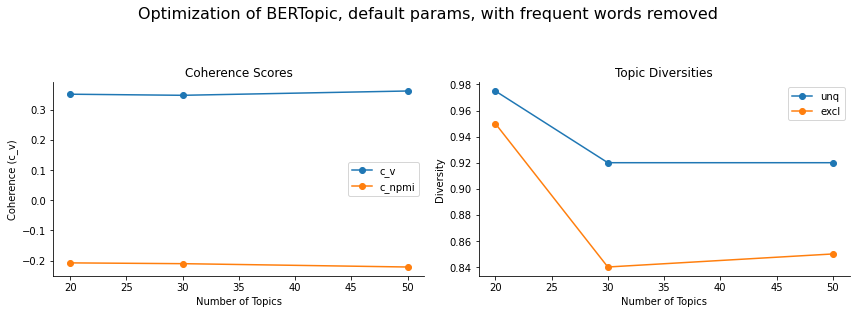

In [21]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(12, 4))
fig.suptitle('Optimization of BERTopic, default params, with frequent words removed', fontsize=16, y=1.08)

# Plot coherence scores
ax1 = plt.subplot(1, 2, 1)
ax1.plot(topic_range, cv_scores, marker='o', label = 'c_v')
ax1.plot(topic_range, cnpmi_scores, marker='o', label = 'c_npmi')
ax1.title.set_text('Coherence Scores')
ax1.legend()
ax1.set_xlabel('Number of Topics')
ax1.set_ylabel('Coherence (c_v)')
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)

# Plot topic diversities
ax2 = plt.subplot(1, 2, 2)
ax2.plot(topic_range, topic_uniqueness, marker='o', label = 'unq')
ax2.plot(topic_range, topic_exclusivity, marker='o', label = 'excl')
ax2.title.set_text('Topic Diversities')
ax2.legend()
ax2.set_xlabel('Number of Topics')
ax2.set_ylabel('Diversity')
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)

plt.tight_layout()

# Save the figure
fig.savefig('training_results/bertopic_default_params_sword_text_optimization2.png', bbox_inches='tight', dpi=300)

plt.show()


<span style="color: orange; font-family: Calibri Light;">
  <h2><b>IV. Select Optimal Model</b></h2>
</span>

In [22]:
# Prepare data, extract embeddings, and prepare sub-models
#docs = train_data['long_text'].values

#umap_model = UMAP(n_neighbors=15, n_components=5, min_dist=0.0, metric='cosine', random_state=142)
#hdbscan_model = HDBSCAN(min_cluster_size = 80, min_samples = 10, metric = 'euclidean', prediction_data = True)
#vectorizer_model = CountVectorizer(stop_words="english", ngram_range=(1,2), max_df = 0.75, min_df = 10)
#sentence_model = SentenceTransformer("all-MiniLM-L6-v2")
#embeddings = sentence_model.encode(docs, show_progress_bar=True)
#representation_model = MaximalMarginalRelevance(diversity = 0.8)


# We reduce our embeddings to 2D as it will allows us to quickly iterate later on
reduced_embeddings = UMAP(n_neighbors=10, n_components=2, 
                          min_dist=0.0, metric='cosine').fit_transform(embeddings)

start_time = time.time()

# Train our topic model
model = BERTopic(embedding_model=sentence_model, umap_model=umap_model, 
                 hdbscan_model = hdbscan_model,vectorizer_model=vectorizer_model,
                 ctfidf_model=ctfidf_model, representation_model=representation_model,
                 nr_topics=50)

topics,_ = model.fit_transform(docs, embeddings)
print (f"This project took {(time.time() - start_time)/60 :.2f} minutes to complete")

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

In [34]:
#save model
model.save("../bertopic_models/model4_default_sw_text_2")
print ('model saved')

/usr/local/lib64/python3.7/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning:

Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.



model saved


In [20]:
#load model
model = BERTopic.load("../bertopic_models/model4_default_sw_text_2")

In [21]:
topics_df = model.get_topic_info()
topics_df.head()

,Topic,Count,Name,Representation,Representative_Docs
0,-1,49024,-1_life_uae_city_didn,"[life, uae, city, didn, lol, say, company, yes...","[I got hired through my work and referrals, be..."
1,0,6786,0_sharjah_uae_muslim_dubai police,"[sharjah, uae, muslim, dubai police, ramadan, ...",[Tailgating is a serious issue here in the UAE...
2,1,3478,1_expo_weather_summer_ac,"[expo, weather, summer, ac, burj khalifa, metr...",[Dudeee it’s the same here. Humidity is f*cked...
3,2,2244,2_vat_maid_years experience_5k,"[vat, maid, years experience, 5k, cv, salaries...",[Why cant i find any job?! I have been despera...
4,3,2233,3_tip_talabat_deliveroo_zomato,"[tip, talabat, deliveroo, zomato, restaurants,...",[Totally agree with the crazy tip asking. In g...


In [25]:
topics_df.to_csv('training_results/bert_default_sw2 _text_topics_term.csv')

In [22]:
top_freq = model.get_topic_freq()
top_freq

,Topic,Count
0,-1,49024
3,0,6786
4,1,3478
27,2,2244
7,3,2233
30,4,2224
12,5,2181
14,6,2058
15,7,2018
22,8,1839


In [ ]:
model.visualize_documents(docs, reduced_embeddings=reduced_embeddings, 
                                hide_document_hover=True, hide_annotations=True)

In [46]:
model.visualize_barchart(top_n_topics = 50, n_words = 10)

In [102]:
model.visualize_barchart(topics = [6,12,1,4,2,33])


<span style="color: orange; font-family: Calibri Light;">
  <h2><b>V. Retrieve Data with Topic Assignments</b></h2>
</span>

In [25]:
#create dataframe with topic assignments
t_df = model.get_document_info(docs)
t_df.head()

,Document,Topic,Name,Representation,Representative_Docs,Top_n_words,Probability,Representative_document
0,That dessert's a bit rich for me.,-1,-1_life_uae_city_didn,"[life, uae, city, didn, lol, say, company, yes...","[I got hired through my work and referrals, be...",life - uae - city - didn - lol - say - company...,0.000000,False
1,"""A SILVER one?! I HATE YOU DAD!""",14,14_award_god bless_wholesome_luck,"[award, god bless, wholesome, luck, prayers, w...",[You are such an amazing person!! Thank you so...,award - god bless - wholesome - luck - prayers...,0.980537,False
2,Yet i stared at the picture for a good 45 seco...,18,18_font_instagram_painting_camera,"[font, instagram, painting, camera, pics, 1k, ...","[Hey, congrats on first 1000 so soon! Can I pl...",font - instagram - painting - camera - pics - ...,0.472592,False
3,"[FYSR] = from your sister subreddit. IMO, its ...",0,0_sharjah_uae_muslim_dubai police,"[sharjah, uae, muslim, dubai police, ramadan, ...",[Tailgating is a serious issue here in the UAE...,sharjah - uae - muslim - dubai police - ramada...,1.000000,False
4,common give prince william harry a break he ju...,-1,-1_life_uae_city_didn,"[life, uae, city, didn, lol, say, company, yes...","[I got hired through my work and referrals, be...",life - uae - city - didn - lol - say - company...,0.000000,False


In [26]:
t_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 98957 entries, 0 to 98956
Data columns (total 8 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Document                 98957 non-null  object 
 1   Topic                    98957 non-null  int64  
 2   Name                     98957 non-null  object 
 3   Representation           98957 non-null  object 
 4   Representative_Docs      98957 non-null  object 
 5   Top_n_words              98957 non-null  object 
 6   Probability              98957 non-null  float64
 7   Representative_document  98957 non-null  bool   
dtypes: bool(1), float64(1), int64(1), object(5)
memory usage: 6.1+ MB


In [82]:
#topic assignment column subset
assigned_topics = t_df[['Topic', 'Name']].copy()
assigned_topics.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 98957 entries, 0 to 98956
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Topic   98957 non-null  int64 
 1   Name    98957 non-null  object
dtypes: int64(1), object(1)
memory usage: 4.3+ MB


In [94]:
train_data_label = train_data.copy() #create copy of training data

In [95]:
train_data_label.reset_index(drop = True, inplace = True) #reindex to match topic assignemtn index

In [96]:
train_data_label[['topic', 'topic_name']] = assigned_topics #merge data

In [97]:
train_data_label.head()

,text_type,ID,date_created,year,long_text,prep_text,topic,topic_name
0,comment,c5c54q4,2012-07-11 00:50:58,2012,That dessert's a bit rich for me.,That dessert's a bit rich for me.,-1,-1_life_uae_city_didn
1,comment,c5edn0u,2012-07-15 21:59:34,2012,"""A SILVER one?! I HATE YOU DAD!""","""A SILVER one?! I HATE YOU DAD!""",14,14_award_god bless_wholesome_luck
2,comment,c6d18gk,2012-09-25 07:57:13,2012,Yet i stared at the picture for a good 45 seco...,Yet i stared at the picture for a good 45 seco...,18,18_font_instagram_painting_camera
3,comment,c6d2fss,2012-09-25 09:13:23,2012,"[FYSR] = from your sister subreddit.\n\nIMO, i...","[FYSR] = from your sister subreddit. IMO, its ...",0,0_sharjah_uae_muslim_dubai police
4,comment,c6d46es,2012-09-25 12:32:08,2012,common give prince william harry a break he ju...,common give prince william harry a break he ju...,-1,-1_life_uae_city_didn


In [98]:
train_data_label.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 98957 entries, 0 to 98956
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   text_type     98957 non-null  object
 1   ID            98957 non-null  object
 2   date_created  98957 non-null  object
 3   year          98957 non-null  int64 
 4   long_text     98957 non-null  object
 5   prep_text     98957 non-null  object
 6   topic         98957 non-null  int64 
 7   topic_name    98957 non-null  object
dtypes: int64(2), object(6)
memory usage: 6.0+ MB


In [100]:
train_data_label.to_csv('training_results/bert_model_2_labelled_train_data.csv') #save training data with topic labels